In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(1000, 2)
Y = np.dot(1.5,np.sin(X[:,0]))+np.exp(np.dot(0.3,X[:,1]))

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

'''min_val_x = X.min()
max_val_x = X.max()

min_val_y = Y.min()
max_val_y = Y.max()

X_train = (X_train - min_val_x) / (max_val_x - min_val_x)
X_test = (X_test - min_val_x) / (max_val_x - min_val_x)

Y_train = (Y_train - min_val_y) / (max_val_y - min_val_y)
Y_test = (Y_test - min_val_y) / (max_val_y - min_val_y)'''

'min_val_x = X.min()\nmax_val_x = X.max()\n\nmin_val_y = Y.min()\nmax_val_y = Y.max()\n\nX_train = (X_train - min_val_x) / (max_val_x - min_val_x)\nX_test = (X_test - min_val_x) / (max_val_x - min_val_x)\n\nY_train = (Y_train - min_val_y) / (max_val_y - min_val_y)\nY_test = (Y_test - min_val_y) / (max_val_y - min_val_y)'

In [3]:

rand_nums = np.random.rand(5)
print(rand_nums)

[0.97050557 0.45998033 0.15287771 0.18950212 0.88423199]


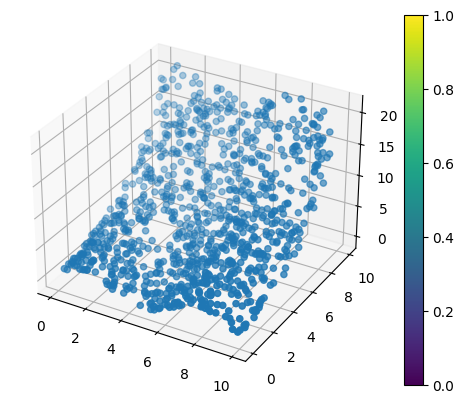

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
surf = ax.scatter3D(X[:,0],X[:,1],Y.reshape(1,-1))
fig.colorbar(surf)

Cobyla with co and with epochs

In [5]:
from scipy.optimize import minimize, Bounds

class non_linear():
    def __init__(self,alpha,epochs = 10):  
        self.alpha = alpha 
        self.epochs = epochs
        self.coef = None   
      
    def output(self,X,beta1,beta2):
        Y = np.dot(beta1,np.sin(X[:,0]))+np.exp(np.dot(beta2,X[:,1])) 
        return Y
    
    def loss(self,beta_j,X,Y,beta,j):  
        beta[j] = beta_j
        loss = (0.5/X.shape[0])* np.linalg.norm(Y- self.output(X,beta[0],beta[1]),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        np.random.seed(123)
        beta = np.random.rand(X.shape[1])                    
            
        for iter in range(self.epochs):           
            
            for j in range(len(beta)):  

                options = {'maxiter': 1000000000}                                      
                                            
                res = minimize(self.loss, x0=beta[j],args=(X,Y,beta,j), method='COBYLA',jac = False, options=options,tol=1e-8)
                                    
                beta[j] = (self.soft_threshold(res.x,1e-4))

            #print(beta)
                    
                
        self.coef = beta
            
        return self
    
    def predict(self, X):
        y = np.dot(self.coef[0],np.sin(X[:,0]))+np.exp(np.dot(self.coef[1],X[:,1]))
                
        return y

In [6]:
lamda = [0,0.0001,0.001,0.01,0.1,1,10]

In [7]:

test_loss = []
wo_cb = np.zeros((len(lamda),X.shape[1]))

for i,val in enumerate(lamda):
    opt_cb = non_linear(val,epochs=1000)
    opt_cb.fit(X_train,Y_train)    
    wo_cb[i,:] = opt_cb.coef
    yp = opt_cb.predict(X_test)
    test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())

In [8]:
print(wo_cb)
print(test_loss)

[[1.5013255  0.2998984 ]
 [1.50110695 0.29989865]
 [1.49914072 0.29990086]
 [1.4794769  0.29992276]
 [1.282843   0.30014173]
 [0.         0.30150247]
 [0.         0.29986081]]
[0.005038780220402312, 0.005014410764206123, 0.005158245686827569, 0.014508372848659619, 0.13721492133108396, 0.9456679290914779, 0.953907016604571]


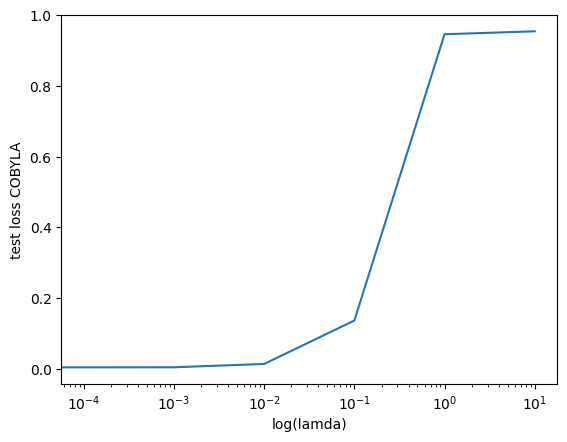

In [9]:
plt.plot(lamda,test_loss)
plt.xscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.show()

COBYLA without co and with epochs

In [10]:
class non_linear_all():
    def __init__(self,alpha,epochs = 10):  
        self.alpha = alpha 
        self.epochs = epochs
        self.coef = None   
      
    def output(self,X,beta1,beta2):
        Y = np.dot(beta1,np.sin(X[:,0]))+np.exp(np.dot(beta2,X[:,1])) 
        return Y
    
    def loss(self,beta,X,Y):         
        loss = (0.5/X.shape[0])* np.linalg.norm(Y- self.output(X,beta[0],beta[1]),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho.all() < - lamda:
            return rho + lamda
        elif rho.all() > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        beta =  np.random.rand(X.shape[1])                    
            
        #for iter in range(self.epochs):            

        options = {'maxiter': 1000000000,'disp':True}                                      
                                                        
        res = minimize(self.loss, x0=beta,args=(X,Y), method='COBYLA',jac = False, options=options,tol=1e-8)
                                                
        beta = (self.soft_threshold(res.x,1e-5))

            #print(beta)
                    
                
        self.coef = beta
            
        return self
    
    def predict(self, X):
        y = np.dot(self.coef[0],np.sin(X[:,0]))+np.exp(np.dot(self.coef[1],X[:,1]))
                
        return y

In [11]:
test_loss_all = []
wo_cb_all = np.zeros((len(lamda),X.shape[1]))

for i,val in enumerate(lamda):
    opt_cb = non_linear_all(val,epochs=1000)
    opt_cb.fit(X_train,Y_train)    
    wo_cb_all[i,:] = opt_cb.coef
    yp = opt_cb.predict(X_test)
    test_loss_all.append((tf.keras.losses.mae(yp, Y_test)).numpy())

In [12]:
print(test_loss_all)
print(test_loss)
print(wo_cb_all)
print(wo_cb)

[0.0005175911670582228, 0.0005273200335661809, 0.0015863673744289002, 0.013740570935546368, 0.13776076796755043, 0.9452959533053221, 0.9556317740125871]
[0.005038780220402312, 0.005014410764206123, 0.005158245686827569, 0.014508372848659619, 0.13721492133108396, 0.9456679290914779, 0.953907016604571]
[[ 1.49990442e+00  2.99990114e-01]
 [ 1.49987383e+00  2.99990133e-01]
 [ 1.49770618e+00  2.99992542e-01]
 [ 1.47825400e+00  3.00014214e-01]
 [ 1.28139809e+00  3.00233451e-01]
 [-1.00060756e-05  3.01595374e-01]
 [-1.00051066e-05  2.99660316e-01]]
[[1.5013255  0.2998984 ]
 [1.50110695 0.29989865]
 [1.49914072 0.29990086]
 [1.4794769  0.29992276]
 [1.282843   0.30014173]
 [0.         0.30150247]
 [0.         0.29986081]]


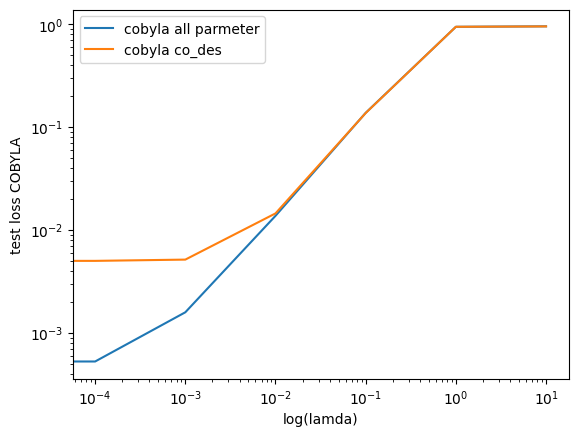

In [13]:
plt.plot(lamda,test_loss_all,label='cobyla all parmeter')
plt.plot(lamda,test_loss,label='cobyla co_des')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.legend()
plt.show()

Coordinate descent

In [14]:
class CoordinateDescentLassoWithoutBias():
    def __init__(self, alpha, epoch= 1000,tol = 1e-4):
        self.alpha = alpha  
        self.epoch = epoch 
        self.tol = tol 
        self.coef = None 

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0 

    def fit(self, X, y):
        m,n = X.shape
        beta = np.zeros(n)        

        for iteration in range(self.epoch):
            beta_old = np.copy(beta)
            
            for j in range(n):
                beta[j] = 0.0
                error = y - np.dot(X, beta)
                rho = np.dot(X[:, j], error)
                lamda = self.alpha*m

                beta[j] = self.soft_threshold( rho, lamda) / (X[:, j]**2).sum()     

            if np.linalg.norm(beta - beta_old) < self.tol:
                print("Optimization converged after", iteration+1, "iterations")
                break   
    
        self.coef = beta
        
        return self

    def predict(self, X):        
        y = np.dot(X, self.coef)        
        return y

In [15]:
w_co = np.zeros((len(lamda),X.shape[1]))
test_co= []

for i,val in enumerate(lamda):
    opt_cb = CoordinateDescentLassoWithoutBias(val,epoch=1000)
    opt_cb.fit(X_train,Y_train)    
    w_co[i,:] = opt_cb.coef
    yp = opt_cb.predict(X_test)
    test_co.append((tf.keras.losses.mae(yp, Y_test)).numpy())
    print(f'weights for lamda {val}: {w_co[i,:]}' )
    print(f' test loss for lamda {val}:{test_co[i]}')


Optimization converged after 18 iterations
weights for lamda 0: [-0.19255295  1.56954559]
 test loss for lamda 0:1.8458238549030677
Optimization converged after 18 iterations
weights for lamda 0.0001: [-0.19254112  1.56953426]
 test loss for lamda 0.0001:1.8458183410663946
Optimization converged after 18 iterations
weights for lamda 0.001: [-0.19243472  1.56943228]
 test loss for lamda 0.001:1.8457687165363403
Optimization converged after 18 iterations
weights for lamda 0.01: [-0.19137065  1.56841244]
 test loss for lamda 0.01:1.8452724712357957
Optimization converged after 18 iterations
weights for lamda 0.1: [-0.18073001  1.55821407]
 test loss for lamda 0.1:1.840310018230345
Optimization converged after 16 iterations
weights for lamda 1: [-0.07427517  1.45619543]
 test loss for lamda 1:1.8204978128399325
Optimization converged after 4 iterations
weights for lamda 10: [0.         1.14988972]
 test loss for lamda 10:2.04185746233745


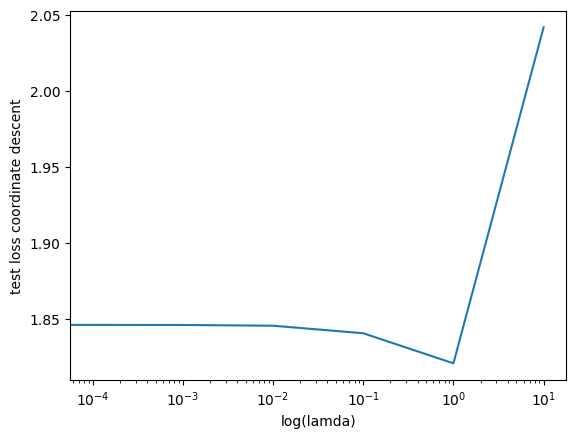

In [16]:
plt.plot(lamda,test_co)
plt.xscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss coordinate descent')
plt.show()

In [17]:
mu=0.0
std = 0.10 * np.std(Y) # for %20 Gaussian noise
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_n = x + noise
    return x_n 

Yn_train = gaussian_noise(Y_train,mu,std)
Yn_test = gaussian_noise(Y_test,mu,std)

In [18]:
test_loss_no = []
wo_cb_no = np.zeros((len(lamda),X.shape[1]))

for i,val in enumerate(lamda):
    opt_cb = non_linear(val,epochs=1000)
    opt_cb.fit(X_train,Yn_train)    
    wo_cb_no[i,:] = opt_cb.coef
    yp = opt_cb.predict(X_test)
    test_loss_no.append((tf.keras.losses.mae(yp, Y_test)).numpy())

In [19]:
print(wo_cb)
print(wo_cb_no)

[[1.5013255  0.2998984 ]
 [1.50110695 0.29989865]
 [1.49914072 0.29990086]
 [1.4794769  0.29992276]
 [1.282843   0.30014173]
 [0.         0.30150247]
 [0.         0.29986081]]
[[1.47871544 0.29975619]
 [1.47849663 0.29975641]
 [1.47653028 0.2997586 ]
 [1.45686669 0.29978058]
 [1.26023217 0.2999998 ]
 [0.         0.30133553]
 [0.         0.29968892]]


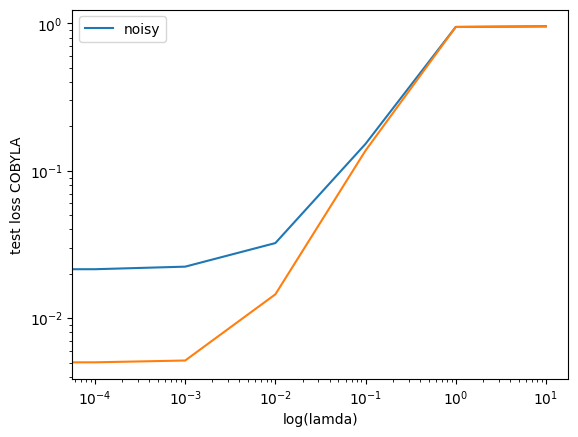

In [20]:
plt.plot(lamda,test_loss_no,label = 'noisy')
plt.plot(lamda,test_loss)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log(lamda)')
plt.ylabel('test loss COBYLA')
plt.legend()
plt.show()

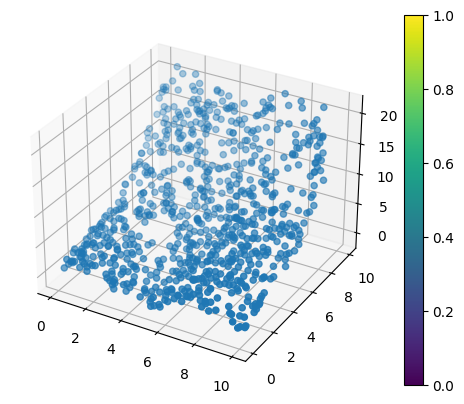

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
surf = ax.scatter3D(X_train[:,0],X_train[:,1],Yn_train.reshape(1,-1))
fig.colorbar(surf)

In [22]:
print(test_loss)
print(test_loss_no)
print(test_co_no)

[0.005038780220402312, 0.005014410764206123, 0.005158245686827569, 0.014508372848659619, 0.13721492133108396, 0.9456679290914779, 0.953907016604571]
[0.021379946644084647, 0.0214787385963562, 0.022355738309867167, 0.032317983645278284, 0.152293635384764, 0.946347279279446, 0.9553756181625462]


NameError: name 'test_co_no' is not defined